In [23]:
from os import listdir
import spacy
import string
import pickle as pkl
import numpy as np
from nltk import ngrams
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

# load data

In [109]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# specify directory to load
directory = '/Users/xintianhan/Downloads/nlp/aclImdb'
directory_train_neg = directory + '/train/neg'
directory_train_pos = directory + '/train/pos'
directory_test_pos = directory + '/test/pos'
directory_test_neg = directory + '/test/neg'
doc_train_pos = []
doc_train_neg = []
doc_test_pos = []
doc_test_neg = []
for filename in listdir(directory_train_neg):
    # create the full path of the file to open
    path = directory_train_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_neg.append(doc)
for filename in listdir(directory_train_pos):
    # create the full path of the file to open
    path = directory_train_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_pos.append(doc)
    
for filename in listdir(directory_test_neg):
    # create the full path of the file to open
    path = directory_test_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_neg.append(doc)

for filename in listdir(directory_test_pos):
    # create the full path of the file to open
    path = directory_test_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_pos.append(doc)

In [110]:
# use 20000 data as train and 5000 as valid
# label 0 for negative and 1 for positive
train_data = doc_train_neg[:10000] + doc_train_pos[:10000]
train_targets = np.zeros(20000)
train_targets[10000:] = np.ones(10000)
val_data = doc_train_neg[10000:] + doc_train_pos[10000:]
val_targets = np.zeros(5000)
val_targets[2500:] = np.ones(2500)
test_data = doc_test_neg + doc_test_pos
test_targets = np.zeros(25000)
test_targets[12500:] = np.ones(12500)

# Tokenization

In [17]:
# Let's write the tokenization function 
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

In [18]:
# tokenize ngram: only_ngram and all_ngram (from 1 to n)
ns = [2,3,4]
all_ngrams = ['T', 'F']
# start tokenize ngram
def tokenize_ngram(sent, n=1, all_ngram = 'T'):
    tokens = tokenizer(sent)
    tokens_unigram =  [token.text.lower() for token in tokens if (token.text not in punctuations)];
    if all_ngram == 'T':
        tokens_ngram = [];
        for i in range(n):
            n_gram = ngrams(tokens_unigram, i+1)
            n_gram = [ ' '.join(grams) for grams in n_gram]
            tokens_ngram += n_gram
    else:
        tokens_ngram =  ngrams(tokens_unigram, n)
        tokens_ngram = [ ' '.join(grams) for grams in tokens_ngram];
    return tokens_ngram


def tokenize_dataset_ngram(dataset, n = 1, all_ngram = 'T'):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize_ngram(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

for n in ns:
    for all_ngram in all_ngrams:
        
        # val set tokens
        print ("Tokenizing val data")
        val_data_tokens, _ = tokenize_dataset_ngram(val_data, n = n, all_ngram = all_ngram)
        pkl.dump(val_data_tokens, open("val_data_tokens"+str(n)+all_ngram+".p", "wb"))

        # test set tokens
        print ("Tokenizing test data")
        test_data_tokens, _ = tokenize_dataset_ngram(test_data)
        pkl.dump(test_data_tokens, open("test_data_tokens"+str(n)+all_ngram+".p", "wb"))

        # train set tokens
        print ("Tokenizing train data")
        train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
        pkl.dump(train_data_tokens, open("train_data_tokens"+str(n)+all_ngram+".p", "wb"))
        pkl.dump(all_train_tokens, open("all_train_tokens"+str(n)+all_ngram+".p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data


# Build the model

In [41]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

MAX_SENTENCE_LENGTH = 200


class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 32

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
    

def plot_func(train_accs, val_accs, filename):
   
    f = plt.figure()
    plt.plot(train_accs, label='train');
    plt.plot(val_accs, label = 'val');
    plt.title(filename);
    plt.legend()
    
    f.savefig(filename + ".pdf", bbox_inches='tight')
    plt.show()
    
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 10 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)

# hyperparameter tuning
### Tokenization schemes of the dataset: 'en_core_web_sm'
### Model hyperparameters: 
#### Vary n for n-gram (n=1, 2, 3, 4)
#### vocabulary size (5000, 10000, 20000)
#### embedding size (100, 200, 500)
### Optimization hyperparameters: 
#### Optimizer itself (SGD vs Adam), 
#### learning rate [0.1, 0.01, 0.001]
#### whether or not you use linear annealing of learning rate (learning rate is reduced linearly over the course of training).


ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.12
Epoch: [1/10], Step: [201/625], Validation Acc: 67.04
Epoch: [1/10], Step: [301/625], Validation Acc: 71.08
Epoch: [1/10], Step: [401/625], Validation Acc: 72.44
Epoch: [1/10], Step: [501/625], Validation Acc: 74.04
Epoch: [1/10], Step: [601/625], Validation Acc: 76.3
Epoch: [2/10], Step: [101/625], Validation Acc: 77.62
Epoch: [2/10], Step: [201/625], Validation Acc: 78.14
Epoch: [2/10], Step: [301/625], Validation Acc: 78.88
Epoch: [2/10], Step: [401/625], Validation Acc: 79.82
Epoch: [2/10], Step: [501/625], Validation Acc: 80.14
Epoch: [2/10], Step: [601/625], Validation Acc: 80.72
Epoch: [3/10], Step: [101/625], Validation Acc: 80.94
Epoch: [3/10], Step: [201/625], Validation Acc: 82.02
Epoch: [3/10], Step: [301/625], Validation Acc: 81.58
Epoch: [3/10], Step: [401/625], Validation Acc: 82.36
Epoch: [3

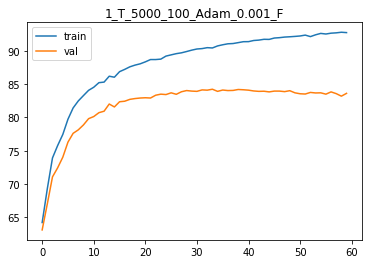

After training for 10 epochs
Train Acc 92.75
Val Acc 83.2
Test Acc 84.812
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.54
Epoch: [1/10], Step: [201/625], Validation Acc: 69.52
Epoch: [1/10], Step: [301/625], Validation Acc: 72.68
Epoch: [1/10], Step: [401/625], Validation Acc: 75.02
Epoch: [1/10], Step: [501/625], Validation Acc: 76.96
Epoch: [1/10], Step: [601/625], Validation Acc: 78.1
Epoch: [2/10], Step: [101/625], Validation Acc: 79.4
Epoch: [2/10], Step: [201/625], Validation Acc: 80.24
Epoch: [2/10], Step: [301/625], Validation Acc: 81.12
Epoch: [2/10], Step: [401/625], Validation Acc: 81.34
Epoch: [2/10], Step: [501/625], Validation Acc: 81.88
Epoch: [2/10], Step: [601/625], Validation Acc: 82.32
Epoch: [3/10], Step: [101/625], Validation Acc: 82.32
Epoch: [3/10], Step: [201/625], Validation Acc: 82.58
Epoch: [3/10], Step: [301/625], Validation A

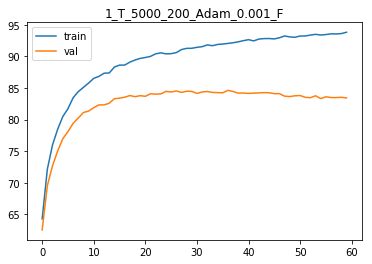

After training for 10 epochs
Train Acc 93.76
Val Acc 83.56
Test Acc 84.708
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 67.46
Epoch: [1/10], Step: [201/625], Validation Acc: 71.68
Epoch: [1/10], Step: [301/625], Validation Acc: 74.82
Epoch: [1/10], Step: [401/625], Validation Acc: 77.0
Epoch: [1/10], Step: [501/625], Validation Acc: 79.02
Epoch: [1/10], Step: [601/625], Validation Acc: 79.84
Epoch: [2/10], Step: [101/625], Validation Acc: 80.8
Epoch: [2/10], Step: [201/625], Validation Acc: 81.88
Epoch: [2/10], Step: [301/625], Validation Acc: 81.88
Epoch: [2/10], Step: [401/625], Validation Acc: 82.52
Epoch: [2/10], Step: [501/625], Validation Acc: 82.3
Epoch: [2/10], Step: [601/625], Validation Acc: 83.18
Epoch: [3/10], Step: [101/625], Validation Acc: 83.52
Epoch: [3/10], Step: [201/625], Validation Acc: 83.52
Epoch: [3/10], Step: [301/625], Validation A

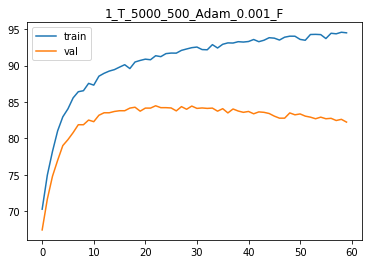

After training for 10 epochs
Train Acc 94.47
Val Acc 82.8
Test Acc 83.992
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 59.46
Epoch: [1/10], Step: [201/625], Validation Acc: 64.5
Epoch: [1/10], Step: [301/625], Validation Acc: 69.24
Epoch: [1/10], Step: [401/625], Validation Acc: 72.28
Epoch: [1/10], Step: [501/625], Validation Acc: 73.38
Epoch: [1/10], Step: [601/625], Validation Acc: 75.2
Epoch: [2/10], Step: [101/625], Validation Acc: 76.62
Epoch: [2/10], Step: [201/625], Validation Acc: 77.56
Epoch: [2/10], Step: [301/625], Validation Acc: 78.46
Epoch: [2/10], Step: [401/625], Validation Acc: 78.76
Epoch: [2/10], Step: [501/625], Validation Acc: 79.74
Epoch: [2/10], Step: [601/625], Validation Acc: 80.24
Epoch: [3/10], Step: [101/625], Validation Acc: 80.44
Epoch: [3/10], Step: [201/625], Validation Acc: 81.16
Epoch: [3/10], Step: [301/625], Validation 

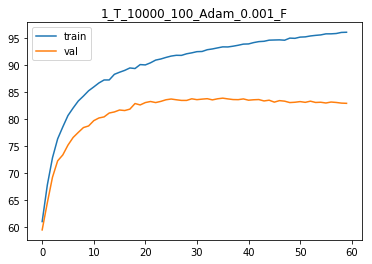

After training for 10 epochs
Train Acc 96.195
Val Acc 83.04
Test Acc 84.7
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.5
Epoch: [1/10], Step: [201/625], Validation Acc: 68.9
Epoch: [1/10], Step: [301/625], Validation Acc: 71.98
Epoch: [1/10], Step: [401/625], Validation Acc: 74.72
Epoch: [1/10], Step: [501/625], Validation Acc: 76.74
Epoch: [1/10], Step: [601/625], Validation Acc: 78.62
Epoch: [2/10], Step: [101/625], Validation Acc: 79.68
Epoch: [2/10], Step: [201/625], Validation Acc: 80.56
Epoch: [2/10], Step: [301/625], Validation Acc: 81.08
Epoch: [2/10], Step: [401/625], Validation Acc: 81.74
Epoch: [2/10], Step: [501/625], Validation Acc: 82.1
Epoch: [2/10], Step: [601/625], Validation Acc: 82.56
Epoch: [3/10], Step: [101/625], Validation Acc: 83.16
Epoch: [3/10], Step: [201/625], Validation Acc: 83.3
Epoch: [3/10], Step: [301/625], Validation Ac

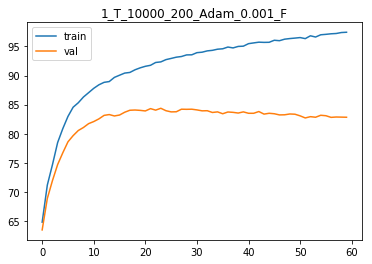

After training for 10 epochs
Train Acc 97.525
Val Acc 82.78
Test Acc 84.192
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 65.68
Epoch: [1/10], Step: [201/625], Validation Acc: 71.78
Epoch: [1/10], Step: [301/625], Validation Acc: 75.18
Epoch: [1/10], Step: [401/625], Validation Acc: 77.56
Epoch: [1/10], Step: [501/625], Validation Acc: 79.18
Epoch: [1/10], Step: [601/625], Validation Acc: 80.1
Epoch: [2/10], Step: [101/625], Validation Acc: 81.5
Epoch: [2/10], Step: [201/625], Validation Acc: 81.86
Epoch: [2/10], Step: [301/625], Validation Acc: 82.84
Epoch: [2/10], Step: [401/625], Validation Acc: 83.08
Epoch: [2/10], Step: [501/625], Validation Acc: 83.22
Epoch: [2/10], Step: [601/625], Validation Acc: 83.06
Epoch: [3/10], Step: [101/625], Validation Acc: 83.78
Epoch: [3/10], Step: [201/625], Validation Acc: 83.9
Epoch: [3/10], Step: [301/625], Validation

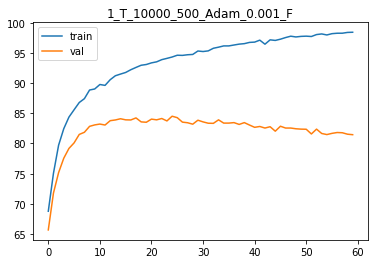

After training for 10 epochs
Train Acc 98.38
Val Acc 81.54
Test Acc 82.868
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.2
Epoch: [1/10], Step: [201/625], Validation Acc: 66.3
Epoch: [1/10], Step: [301/625], Validation Acc: 69.56
Epoch: [1/10], Step: [401/625], Validation Acc: 73.3
Epoch: [1/10], Step: [501/625], Validation Acc: 75.3
Epoch: [1/10], Step: [601/625], Validation Acc: 76.7
Epoch: [2/10], Step: [101/625], Validation Acc: 78.02
Epoch: [2/10], Step: [201/625], Validation Acc: 78.94
Epoch: [2/10], Step: [301/625], Validation Acc: 79.58
Epoch: [2/10], Step: [401/625], Validation Acc: 80.5
Epoch: [2/10], Step: [501/625], Validation Acc: 80.64
Epoch: [2/10], Step: [601/625], Validation Acc: 81.42
Epoch: [3/10], Step: [101/625], Validation Acc: 81.84
Epoch: [3/10], Step: [201/625], Validation Acc: 82.1
Epoch: [3/10], Step: [301/625], Validation Acc:

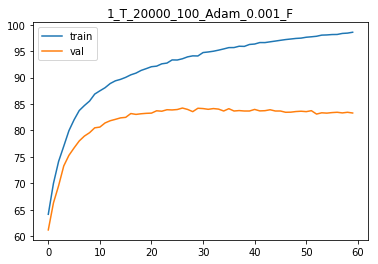

After training for 10 epochs
Train Acc 98.555
Val Acc 82.94
Test Acc 84.096
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.42
Epoch: [1/10], Step: [201/625], Validation Acc: 69.8
Epoch: [1/10], Step: [301/625], Validation Acc: 72.7
Epoch: [1/10], Step: [401/625], Validation Acc: 75.4
Epoch: [1/10], Step: [501/625], Validation Acc: 77.58
Epoch: [1/10], Step: [601/625], Validation Acc: 78.68
Epoch: [2/10], Step: [101/625], Validation Acc: 79.92
Epoch: [2/10], Step: [201/625], Validation Acc: 80.8
Epoch: [2/10], Step: [301/625], Validation Acc: 81.58
Epoch: [2/10], Step: [401/625], Validation Acc: 82.02
Epoch: [2/10], Step: [501/625], Validation Acc: 82.34
Epoch: [2/10], Step: [601/625], Validation Acc: 82.9
Epoch: [3/10], Step: [101/625], Validation Acc: 83.46
Epoch: [3/10], Step: [201/625], Validation Acc: 83.5
Epoch: [3/10], Step: [301/625], Validation Ac

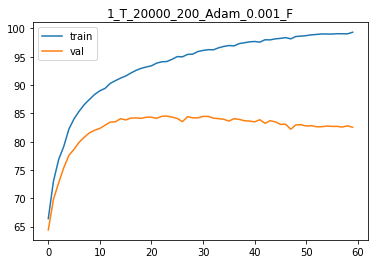

After training for 10 epochs
Train Acc 99.32
Val Acc 82.48
Test Acc 83.78
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 66.24
Epoch: [1/10], Step: [201/625], Validation Acc: 71.68
Epoch: [1/10], Step: [301/625], Validation Acc: 75.52
Epoch: [1/10], Step: [401/625], Validation Acc: 76.8
Epoch: [1/10], Step: [501/625], Validation Acc: 78.74
Epoch: [1/10], Step: [601/625], Validation Acc: 79.12
Epoch: [2/10], Step: [101/625], Validation Acc: 80.98
Epoch: [2/10], Step: [201/625], Validation Acc: 81.5
Epoch: [2/10], Step: [301/625], Validation Acc: 82.36
Epoch: [2/10], Step: [401/625], Validation Acc: 82.7
Epoch: [2/10], Step: [501/625], Validation Acc: 83.52
Epoch: [2/10], Step: [601/625], Validation Acc: 83.6
Epoch: [3/10], Step: [101/625], Validation Acc: 83.24
Epoch: [3/10], Step: [201/625], Validation Acc: 83.06
Epoch: [3/10], Step: [301/625], Validation Ac

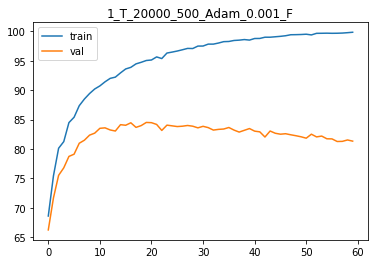

After training for 10 epochs
Train Acc 99.87
Val Acc 81.54
Test Acc 82.848
The best model selected on the validation set has
best_n:  1
best_all_ngram:  T
best_max_vocab_size:  5000
best_emb_dim:  500
best_optim:  Adam
best_lr:  0.001
best_lr_decay:  F
train_acc:  93.76


NameError: name 'best_val_acc' is not defined

In [42]:
# We use a greedy search over single hyperparameters.
# First fixed n-gram = unigram, Adam, fixed-learning rate = 0.001, test vocabulary size and embedding size
# Then, load preprocessed train, val and test datasets
best_valid_acc = 0
ns = [1]
all_ngrams = ['T']
max_vocab_sizes = [5000, 10000, 20000]
emb_dims = [100, 200, 500]
lrs = [0.001]
lr_decays = ['F']
optims = ['Adam']
for n in ns:
    for all_ngram in all_ngrams:
        for max_vocab_size in max_vocab_sizes:
            for emb_dim in emb_dims:
                for lr in lrs:
                    for lr_decay in lr_decays:
                        for optim in optims:
                            train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
                            if val_acc > best_valid_acc:
                                best_n = n
                                best_all_ngram = all_ngram
                                best_max_vocab_size = max_vocab_size
                                best_emb_dim = emb_dim
                                best_optim = optim
                                best_lr = lr
                                best_lr_decay = lr_decay
                                best_valid_acc = val_acc
                                best_test_acc = test_acc
                                best_train_acc = train_acc
print('The best model selected on the validation set has')
print('best_n: ', best_n)
print('best_all_ngram: ', best_all_ngram)
print('best_max_vocab_size: ', best_max_vocab_size)
print('best_emb_dim: ', best_emb_dim)
print('best_optim: ', best_optim)
print('best_lr: ', lr)
print('best_lr_decay: ', lr_decay)
print('train_acc: ', best_train_acc)
print('val_acc: ', best_val_acc)
print('test_acc: ', best_test_acc)

ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.36
Epoch: [1/10], Step: [201/625], Validation Acc: 67.44
Epoch: [1/10], Step: [301/625], Validation Acc: 73.16
Epoch: [1/10], Step: [401/625], Validation Acc: 75.26
Epoch: [1/10], Step: [501/625], Validation Acc: 77.22
Epoch: [1/10], Step: [601/625], Validation Acc: 77.16
Epoch: [2/10], Step: [101/625], Validation Acc: 78.8
Epoch: [2/10], Step: [201/625], Validation Acc: 79.96
Epoch: [2/10], Step: [301/625], Validation Acc: 80.2
Epoch: [2/10], Step: [401/625], Validation Acc: 80.82
Epoch: [2/10], Step: [501/625], Validation Acc: 81.34
Epoch: [2/10], Step: [601/625], Validation Acc: 81.48
Epoch: [3/10], Step: [101/625], Validation Acc: 82.22
Epoch: [3/10], Step: [201/625], Validation Acc: 82.34
Epoch: [3/10], Step: [301/625], Validation Acc: 82.6
Epoch: [3/10], Step: [401/625], Validation Acc: 83.04
Epoch: [3/1

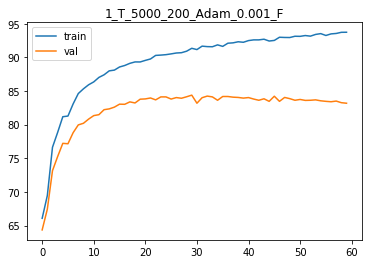

After training for 10 epochs
Train Acc 93.795
Val Acc 83.34
Test Acc 84.552
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.56
Epoch: [1/10], Step: [201/625], Validation Acc: 68.44
Epoch: [1/10], Step: [301/625], Validation Acc: 70.72
Epoch: [1/10], Step: [401/625], Validation Acc: 74.52
Epoch: [1/10], Step: [501/625], Validation Acc: 77.38
Epoch: [1/10], Step: [601/625], Validation Acc: 77.18
Epoch: [2/10], Step: [101/625], Validation Acc: 79.88
Epoch: [2/10], Step: [201/625], Validation Acc: 80.76
Epoch: [2/10], Step: [301/625], Validation Acc: 80.56
Epoch: [2/10], Step: [401/625], Validation Acc: 81.14
Epoch: [2/10], Step: [501/625], Validation Acc: 81.62
Epoch: [2/10], Step: [601/625], Validation Acc: 82.1
Epoch: [3/10], Step: [101/625], Validation Acc: 82.64
Epoch: [3/10], Step: [201/625], Validation Acc: 82.6
Epoch: [3/10], Step: [301/625], Validation

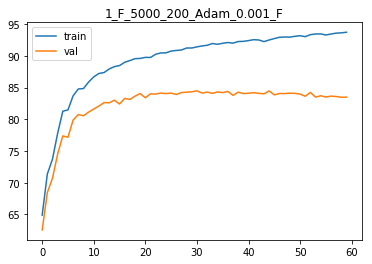

After training for 10 epochs
Train Acc 93.345
Val Acc 83.04
Test Acc 84.252
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.34
Epoch: [1/10], Step: [201/625], Validation Acc: 70.62
Epoch: [1/10], Step: [301/625], Validation Acc: 73.84
Epoch: [1/10], Step: [401/625], Validation Acc: 75.32
Epoch: [1/10], Step: [501/625], Validation Acc: 77.3
Epoch: [1/10], Step: [601/625], Validation Acc: 78.62
Epoch: [2/10], Step: [101/625], Validation Acc: 79.36
Epoch: [2/10], Step: [201/625], Validation Acc: 79.92
Epoch: [2/10], Step: [301/625], Validation Acc: 80.6
Epoch: [2/10], Step: [401/625], Validation Acc: 81.32
Epoch: [2/10], Step: [501/625], Validation Acc: 81.94
Epoch: [2/10], Step: [601/625], Validation Acc: 82.04
Epoch: [3/10], Step: [101/625], Validation Acc: 82.06
Epoch: [3/10], Step: [201/625], Validation Acc: 82.56
Epoch: [3/10], Step: [301/625], Validation

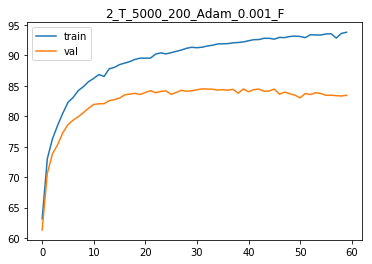

After training for 10 epochs
Train Acc 93.69
Val Acc 83.48
Test Acc 84.764
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 65.26
Epoch: [1/10], Step: [201/625], Validation Acc: 67.54
Epoch: [1/10], Step: [301/625], Validation Acc: 71.26
Epoch: [1/10], Step: [401/625], Validation Acc: 73.28
Epoch: [1/10], Step: [501/625], Validation Acc: 76.2
Epoch: [1/10], Step: [601/625], Validation Acc: 77.36
Epoch: [2/10], Step: [101/625], Validation Acc: 78.78
Epoch: [2/10], Step: [201/625], Validation Acc: 79.62
Epoch: [2/10], Step: [301/625], Validation Acc: 80.5
Epoch: [2/10], Step: [401/625], Validation Acc: 81.2
Epoch: [2/10], Step: [501/625], Validation Acc: 81.46
Epoch: [2/10], Step: [601/625], Validation Acc: 81.96
Epoch: [3/10], Step: [101/625], Validation Acc: 82.52
Epoch: [3/10], Step: [201/625], Validation Acc: 82.9
Epoch: [3/10], Step: [301/625], Validation Ac

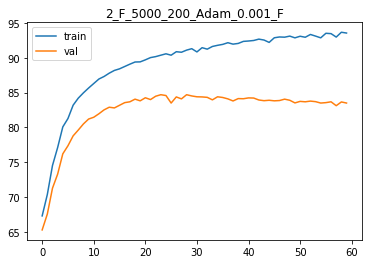

After training for 10 epochs
Train Acc 93.76
Val Acc 83.82
Test Acc 84.796
ngram:  3
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.18
Epoch: [1/10], Step: [201/625], Validation Acc: 69.26
Epoch: [1/10], Step: [301/625], Validation Acc: 71.6
Epoch: [1/10], Step: [401/625], Validation Acc: 74.24
Epoch: [1/10], Step: [501/625], Validation Acc: 76.04
Epoch: [1/10], Step: [601/625], Validation Acc: 77.32
Epoch: [2/10], Step: [101/625], Validation Acc: 78.74
Epoch: [2/10], Step: [201/625], Validation Acc: 79.82
Epoch: [2/10], Step: [301/625], Validation Acc: 80.58
Epoch: [2/10], Step: [401/625], Validation Acc: 81.26
Epoch: [2/10], Step: [501/625], Validation Acc: 81.62
Epoch: [2/10], Step: [601/625], Validation Acc: 82.02
Epoch: [3/10], Step: [101/625], Validation Acc: 82.24
Epoch: [3/10], Step: [201/625], Validation Acc: 82.78
Epoch: [3/10], Step: [301/625], Validation

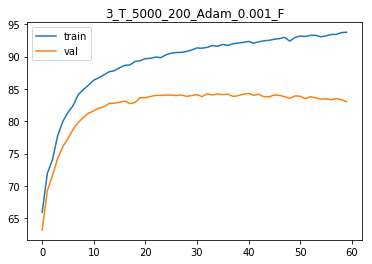

After training for 10 epochs
Train Acc 93.465
Val Acc 83.14
Test Acc 84.616
ngram:  3
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.16
Epoch: [1/10], Step: [201/625], Validation Acc: 67.4
Epoch: [1/10], Step: [301/625], Validation Acc: 72.46
Epoch: [1/10], Step: [401/625], Validation Acc: 75.26
Epoch: [1/10], Step: [501/625], Validation Acc: 76.68
Epoch: [1/10], Step: [601/625], Validation Acc: 77.72
Epoch: [2/10], Step: [101/625], Validation Acc: 79.02
Epoch: [2/10], Step: [201/625], Validation Acc: 79.64
Epoch: [2/10], Step: [301/625], Validation Acc: 80.18
Epoch: [2/10], Step: [401/625], Validation Acc: 80.6
Epoch: [2/10], Step: [501/625], Validation Acc: 81.24
Epoch: [2/10], Step: [601/625], Validation Acc: 81.78
Epoch: [3/10], Step: [101/625], Validation Acc: 82.02
Epoch: [3/10], Step: [201/625], Validation Acc: 82.4
Epoch: [3/10], Step: [301/625], Validation 

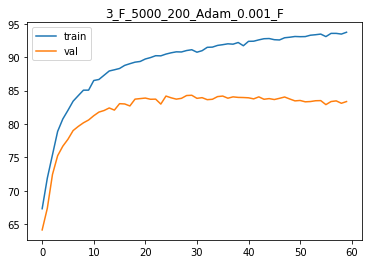

After training for 10 epochs
Train Acc 93.71
Val Acc 83.4
Test Acc 84.784
ngram:  4
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.76
Epoch: [1/10], Step: [201/625], Validation Acc: 68.9
Epoch: [1/10], Step: [301/625], Validation Acc: 72.22
Epoch: [1/10], Step: [401/625], Validation Acc: 74.88
Epoch: [1/10], Step: [501/625], Validation Acc: 76.72
Epoch: [1/10], Step: [601/625], Validation Acc: 78.1
Epoch: [2/10], Step: [101/625], Validation Acc: 79.34
Epoch: [2/10], Step: [201/625], Validation Acc: 79.98
Epoch: [2/10], Step: [301/625], Validation Acc: 80.16
Epoch: [2/10], Step: [401/625], Validation Acc: 80.74
Epoch: [2/10], Step: [501/625], Validation Acc: 81.3
Epoch: [2/10], Step: [601/625], Validation Acc: 81.84
Epoch: [3/10], Step: [101/625], Validation Acc: 82.66
Epoch: [3/10], Step: [201/625], Validation Acc: 82.34
Epoch: [3/10], Step: [301/625], Validation Ac

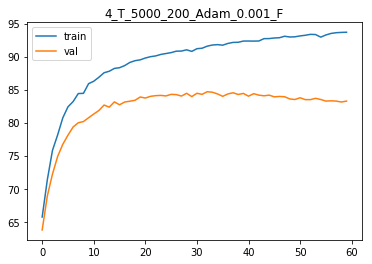

After training for 10 epochs
Train Acc 93.665
Val Acc 83.12
Test Acc 84.412
ngram:  4
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.96
Epoch: [1/10], Step: [201/625], Validation Acc: 68.8
Epoch: [1/10], Step: [301/625], Validation Acc: 72.16
Epoch: [1/10], Step: [401/625], Validation Acc: 74.94
Epoch: [1/10], Step: [501/625], Validation Acc: 76.28
Epoch: [1/10], Step: [601/625], Validation Acc: 77.94
Epoch: [2/10], Step: [101/625], Validation Acc: 79.14
Epoch: [2/10], Step: [201/625], Validation Acc: 80.32
Epoch: [2/10], Step: [301/625], Validation Acc: 80.74
Epoch: [2/10], Step: [401/625], Validation Acc: 81.5
Epoch: [2/10], Step: [501/625], Validation Acc: 81.48
Epoch: [2/10], Step: [601/625], Validation Acc: 82.08
Epoch: [3/10], Step: [101/625], Validation Acc: 82.58
Epoch: [3/10], Step: [201/625], Validation Acc: 82.74
Epoch: [3/10], Step: [301/625], Validation

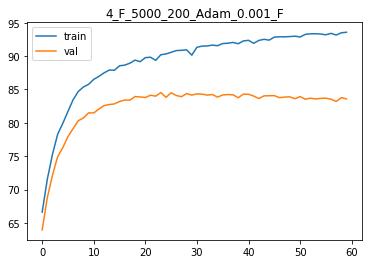

After training for 10 epochs
Train Acc 92.97
Val Acc 82.48
Test Acc 83.788
The best model selected on the validation set has
best_n:  2
best_all_ngram:  F
best_max_vocab_size:  5000
best_emb_dim:  200
best_optim:  Adam
best_lr:  0.001
best_lr_decay:  F
train_acc:  93.76
val_acc:  83.82
test_acc:  84.796


In [47]:
# Then we test ngram settings. We fix optim = Adam, lr = 0.001, lr_decay = F, max_vocab_size = 5000, emb_size = 500.
# enumerative search
best_valid_acc = 0
ns = [1,2,3,4]
all_ngrams = ['T','F']
max_vocab_sizes = [5000]
emb_dims = [200]
lrs = [0.001]
lr_decays = [ 'F']
optims = ['Adam']
val_accs = []
for n in ns:
    for all_ngram in all_ngrams:
        for max_vocab_size in max_vocab_sizes:
            for emb_dim in emb_dims:
                for lr in lrs:
                    for lr_decay in lr_decays:
                        for optim in optims:
                            train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
                            val_accs.append(val_acc)
                            if val_acc > best_valid_acc:
                                best_n = n
                                best_all_ngram = all_ngram
                                best_max_vocab_size = max_vocab_size
                                best_emb_dim = emb_dim
                                best_optim = optim
                                best_lr = lr
                                best_lr_decay = lr_decay
                                best_valid_acc = val_acc
                                best_test_acc = test_acc
                                best_train_acc = train_acc
print('The best model selected on the validation set has')
print('best_n: ', best_n)
print('best_all_ngram: ', best_all_ngram)
print('best_max_vocab_size: ', best_max_vocab_size)
print('best_emb_dim: ', best_emb_dim)
print('best_optim: ', best_optim)
print('best_lr: ', lr)
print('best_lr_decay: ', lr_decay)
print('train_acc: ', best_train_acc)
print('val_acc: ', best_valid_acc)
print('test_acc: ', best_test_acc)

ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 73.02
Epoch: [1/10], Step: [201/625], Validation Acc: 72.04
Epoch: [1/10], Step: [301/625], Validation Acc: 77.66
Epoch: [1/10], Step: [401/625], Validation Acc: 80.52
Epoch: [1/10], Step: [501/625], Validation Acc: 70.4
Epoch: [1/10], Step: [601/625], Validation Acc: 80.9
Epoch: [2/10], Step: [101/625], Validation Acc: 79.78
Epoch: [2/10], Step: [201/625], Validation Acc: 81.06
Epoch: [2/10], Step: [301/625], Validation Acc: 79.32
Epoch: [2/10], Step: [401/625], Validation Acc: 73.3
Epoch: [2/10], Step: [501/625], Validation Acc: 79.54
Epoch: [2/10], Step: [601/625], Validation Acc: 78.56
Epoch: [3/10], Step: [101/625], Validation Acc: 78.96
Epoch: [3/10], Step: [201/625], Validation Acc: 81.68
Epoch: [3/10], Step: [301/625], Validation Acc: 79.12
Epoch: [3/10], Step: [401/625], Validation Acc: 79.44
Epoch: [3/10]

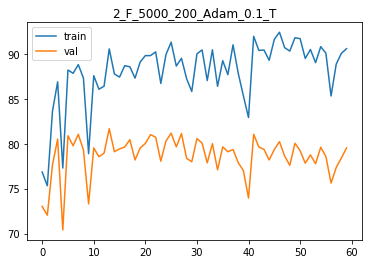

After training for 10 epochs
Train Acc 87.475
Val Acc 76.08
Test Acc 78.04
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.04
Epoch: [1/10], Step: [201/625], Validation Acc: 58.96
Epoch: [1/10], Step: [301/625], Validation Acc: 63.0
Epoch: [1/10], Step: [401/625], Validation Acc: 63.86
Epoch: [1/10], Step: [501/625], Validation Acc: 63.62
Epoch: [1/10], Step: [601/625], Validation Acc: 64.1
Epoch: [2/10], Step: [101/625], Validation Acc: 64.34
Epoch: [2/10], Step: [201/625], Validation Acc: 65.04
Epoch: [2/10], Step: [301/625], Validation Acc: 65.54
Epoch: [2/10], Step: [401/625], Validation Acc: 66.0
Epoch: [2/10], Step: [501/625], Validation Acc: 65.0
Epoch: [2/10], Step: [601/625], Validation Acc: 67.04
Epoch: [3/10], Step: [101/625], Validation Acc: 67.08
Epoch: [3/10], Step: [201/625], Validation Acc: 66.3
Epoch: [3/10], Step: [301/625], Validation Acc: 6

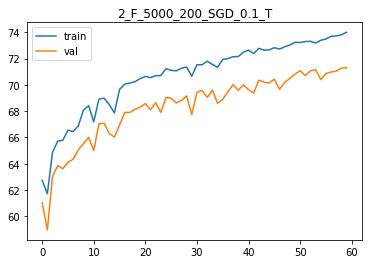

After training for 10 epochs
Train Acc 73.98
Val Acc 71.44
Test Acc 73.188
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.06
Epoch: [1/10], Step: [201/625], Validation Acc: 75.54
Epoch: [1/10], Step: [301/625], Validation Acc: 72.44
Epoch: [1/10], Step: [401/625], Validation Acc: 81.84
Epoch: [1/10], Step: [501/625], Validation Acc: 77.54
Epoch: [1/10], Step: [601/625], Validation Acc: 74.42
Epoch: [2/10], Step: [101/625], Validation Acc: 80.44
Epoch: [2/10], Step: [201/625], Validation Acc: 78.96
Epoch: [2/10], Step: [301/625], Validation Acc: 77.04
Epoch: [2/10], Step: [401/625], Validation Acc: 77.24
Epoch: [2/10], Step: [501/625], Validation Acc: 76.02
Epoch: [2/10], Step: [601/625], Validation Acc: 79.7
Epoch: [3/10], Step: [101/625], Validation Acc: 81.22
Epoch: [3/10], Step: [201/625], Validation Acc: 78.32
Epoch: [3/10], Step: [301/625], Validation A

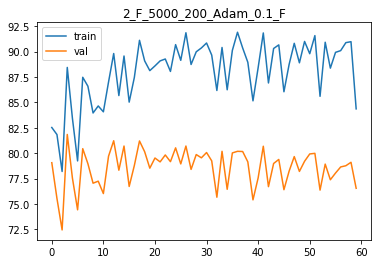

After training for 10 epochs
Train Acc 89.945
Val Acc 80.0
Test Acc 80.98
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 53.56
Epoch: [1/10], Step: [201/625], Validation Acc: 58.98
Epoch: [1/10], Step: [301/625], Validation Acc: 63.56
Epoch: [1/10], Step: [401/625], Validation Acc: 63.46
Epoch: [1/10], Step: [501/625], Validation Acc: 64.08
Epoch: [1/10], Step: [601/625], Validation Acc: 64.18
Epoch: [2/10], Step: [101/625], Validation Acc: 64.36
Epoch: [2/10], Step: [201/625], Validation Acc: 65.86
Epoch: [2/10], Step: [301/625], Validation Acc: 65.68
Epoch: [2/10], Step: [401/625], Validation Acc: 66.0
Epoch: [2/10], Step: [501/625], Validation Acc: 66.28
Epoch: [2/10], Step: [601/625], Validation Acc: 65.52
Epoch: [3/10], Step: [101/625], Validation Acc: 66.98
Epoch: [3/10], Step: [201/625], Validation Acc: 66.8
Epoch: [3/10], Step: [301/625], Validation Acc:

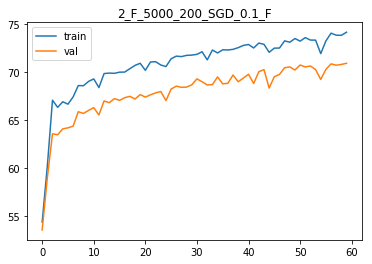

After training for 10 epochs
Train Acc 74.105
Val Acc 71.08
Test Acc 73.168
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.48
Epoch: [1/10], Step: [201/625], Validation Acc: 81.9
Epoch: [1/10], Step: [301/625], Validation Acc: 82.8
Epoch: [1/10], Step: [401/625], Validation Acc: 82.7
Epoch: [1/10], Step: [501/625], Validation Acc: 83.34
Epoch: [1/10], Step: [601/625], Validation Acc: 82.5
Epoch: [2/10], Step: [101/625], Validation Acc: 83.76
Epoch: [2/10], Step: [201/625], Validation Acc: 83.66
Epoch: [2/10], Step: [301/625], Validation Acc: 82.84
Epoch: [2/10], Step: [401/625], Validation Acc: 83.06
Epoch: [2/10], Step: [501/625], Validation Acc: 82.7
Epoch: [2/10], Step: [601/625], Validation Acc: 83.34
Epoch: [3/10], Step: [101/625], Validation Acc: 82.08
Epoch: [3/10], Step: [201/625], Validation Acc: 82.82
Epoch: [3/10], Step: [301/625], Validation Acc

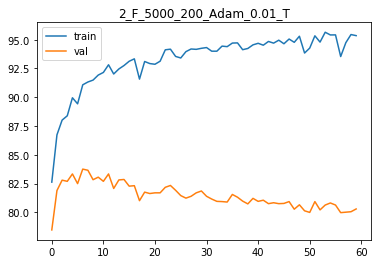

After training for 10 epochs
Train Acc 94.86
Val Acc 80.08
Test Acc 81.864
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.32
Epoch: [1/10], Step: [201/625], Validation Acc: 53.0
Epoch: [1/10], Step: [301/625], Validation Acc: 54.34
Epoch: [1/10], Step: [401/625], Validation Acc: 55.0
Epoch: [1/10], Step: [501/625], Validation Acc: 56.66
Epoch: [1/10], Step: [601/625], Validation Acc: 56.76
Epoch: [2/10], Step: [101/625], Validation Acc: 58.28
Epoch: [2/10], Step: [201/625], Validation Acc: 58.12
Epoch: [2/10], Step: [301/625], Validation Acc: 59.04
Epoch: [2/10], Step: [401/625], Validation Acc: 60.56
Epoch: [2/10], Step: [501/625], Validation Acc: 60.14
Epoch: [2/10], Step: [601/625], Validation Acc: 61.28
Epoch: [3/10], Step: [101/625], Validation Acc: 61.7
Epoch: [3/10], Step: [201/625], Validation Acc: 61.84
Epoch: [3/10], Step: [301/625], Validation Acc

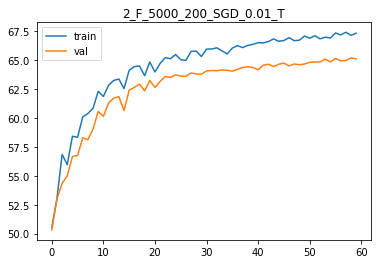

After training for 10 epochs
Train Acc 67.465
Val Acc 64.94
Test Acc 67.048
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.08
Epoch: [1/10], Step: [201/625], Validation Acc: 80.46
Epoch: [1/10], Step: [301/625], Validation Acc: 82.6
Epoch: [1/10], Step: [401/625], Validation Acc: 82.8
Epoch: [1/10], Step: [501/625], Validation Acc: 82.84
Epoch: [1/10], Step: [601/625], Validation Acc: 82.74
Epoch: [2/10], Step: [101/625], Validation Acc: 82.72
Epoch: [2/10], Step: [201/625], Validation Acc: 83.58
Epoch: [2/10], Step: [301/625], Validation Acc: 82.02
Epoch: [2/10], Step: [401/625], Validation Acc: 82.5
Epoch: [2/10], Step: [501/625], Validation Acc: 82.96
Epoch: [2/10], Step: [601/625], Validation Acc: 83.38
Epoch: [3/10], Step: [101/625], Validation Acc: 83.1
Epoch: [3/10], Step: [201/625], Validation Acc: 83.24
Epoch: [3/10], Step: [301/625], Validation Ac

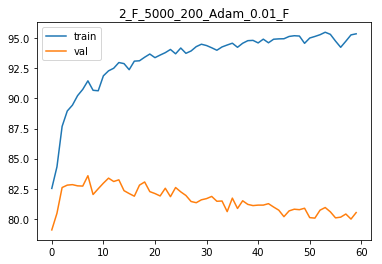

After training for 10 epochs
Train Acc 95.45
Val Acc 80.36
Test Acc 81.612
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 53.92
Epoch: [1/10], Step: [201/625], Validation Acc: 54.78
Epoch: [1/10], Step: [301/625], Validation Acc: 56.16
Epoch: [1/10], Step: [401/625], Validation Acc: 56.38
Epoch: [1/10], Step: [501/625], Validation Acc: 57.62
Epoch: [1/10], Step: [601/625], Validation Acc: 58.54
Epoch: [2/10], Step: [101/625], Validation Acc: 58.8
Epoch: [2/10], Step: [201/625], Validation Acc: 58.88
Epoch: [2/10], Step: [301/625], Validation Acc: 59.84
Epoch: [2/10], Step: [401/625], Validation Acc: 60.1
Epoch: [2/10], Step: [501/625], Validation Acc: 60.44
Epoch: [2/10], Step: [601/625], Validation Acc: 60.44
Epoch: [3/10], Step: [101/625], Validation Acc: 61.0
Epoch: [3/10], Step: [201/625], Validation Acc: 60.96
Epoch: [3/10], Step: [301/625], Validation Acc

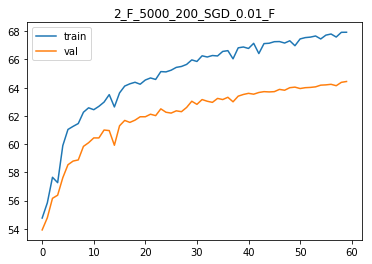

After training for 10 epochs
Train Acc 67.975
Val Acc 64.32
Test Acc 66.948
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.62
Epoch: [1/10], Step: [201/625], Validation Acc: 67.88
Epoch: [1/10], Step: [301/625], Validation Acc: 70.64
Epoch: [1/10], Step: [401/625], Validation Acc: 74.16
Epoch: [1/10], Step: [501/625], Validation Acc: 76.16
Epoch: [1/10], Step: [601/625], Validation Acc: 77.42
Epoch: [2/10], Step: [101/625], Validation Acc: 78.68
Epoch: [2/10], Step: [201/625], Validation Acc: 79.36
Epoch: [2/10], Step: [301/625], Validation Acc: 80.26
Epoch: [2/10], Step: [401/625], Validation Acc: 81.02
Epoch: [2/10], Step: [501/625], Validation Acc: 81.66
Epoch: [2/10], Step: [601/625], Validation Acc: 81.92
Epoch: [3/10], Step: [101/625], Validation Acc: 82.16
Epoch: [3/10], Step: [201/625], Validation Acc: 82.3
Epoch: [3/10], Step: [301/625], Validatio

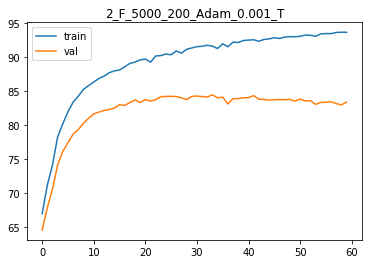

After training for 10 epochs
Train Acc 93.525
Val Acc 83.0
Test Acc 84.488
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.72
Epoch: [1/10], Step: [201/625], Validation Acc: 51.92
Epoch: [1/10], Step: [301/625], Validation Acc: 51.76
Epoch: [1/10], Step: [401/625], Validation Acc: 51.4
Epoch: [1/10], Step: [501/625], Validation Acc: 51.7
Epoch: [1/10], Step: [601/625], Validation Acc: 52.14
Epoch: [2/10], Step: [101/625], Validation Acc: 52.42
Epoch: [2/10], Step: [201/625], Validation Acc: 52.56
Epoch: [2/10], Step: [301/625], Validation Acc: 52.88
Epoch: [2/10], Step: [401/625], Validation Acc: 52.94
Epoch: [2/10], Step: [501/625], Validation Acc: 52.88
Epoch: [2/10], Step: [601/625], Validation Acc: 52.6
Epoch: [3/10], Step: [101/625], Validation Acc: 52.5
Epoch: [3/10], Step: [201/625], Validation Acc: 52.9
Epoch: [3/10], Step: [301/625], Validation Acc:

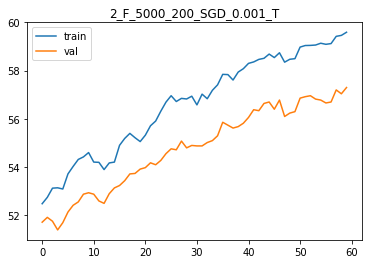

After training for 10 epochs
Train Acc 59.455
Val Acc 56.94
Test Acc 58.608
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.56
Epoch: [1/10], Step: [201/625], Validation Acc: 70.26
Epoch: [1/10], Step: [301/625], Validation Acc: 72.74
Epoch: [1/10], Step: [401/625], Validation Acc: 76.04
Epoch: [1/10], Step: [501/625], Validation Acc: 77.9
Epoch: [1/10], Step: [601/625], Validation Acc: 78.82
Epoch: [2/10], Step: [101/625], Validation Acc: 79.12
Epoch: [2/10], Step: [201/625], Validation Acc: 80.38
Epoch: [2/10], Step: [301/625], Validation Acc: 80.62
Epoch: [2/10], Step: [401/625], Validation Acc: 81.58
Epoch: [2/10], Step: [501/625], Validation Acc: 82.3
Epoch: [2/10], Step: [601/625], Validation Acc: 82.8
Epoch: [3/10], Step: [101/625], Validation Acc: 82.68
Epoch: [3/10], Step: [201/625], Validation Acc: 82.98
Epoch: [3/10], Step: [301/625], Validation 

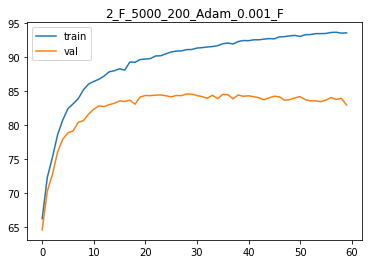

After training for 10 epochs
Train Acc 93.7
Val Acc 83.24
Test Acc 84.528
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.98
Epoch: [1/10], Step: [201/625], Validation Acc: 52.64
Epoch: [1/10], Step: [301/625], Validation Acc: 53.52
Epoch: [1/10], Step: [401/625], Validation Acc: 53.9
Epoch: [1/10], Step: [501/625], Validation Acc: 54.06
Epoch: [1/10], Step: [601/625], Validation Acc: 54.24
Epoch: [2/10], Step: [101/625], Validation Acc: 54.6
Epoch: [2/10], Step: [201/625], Validation Acc: 54.58
Epoch: [2/10], Step: [301/625], Validation Acc: 55.06
Epoch: [2/10], Step: [401/625], Validation Acc: 55.04
Epoch: [2/10], Step: [501/625], Validation Acc: 54.88
Epoch: [2/10], Step: [601/625], Validation Acc: 55.58
Epoch: [3/10], Step: [101/625], Validation Acc: 55.76
Epoch: [3/10], Step: [201/625], Validation Acc: 56.04
Epoch: [3/10], Step: [301/625], Validation Ac

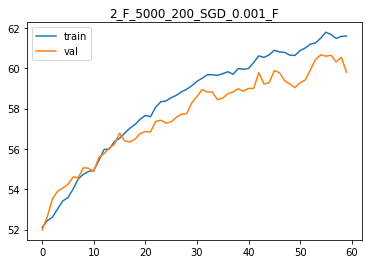

After training for 10 epochs
Train Acc 61.635
Val Acc 59.9
Test Acc 61.32
The best model selected on the validation set has
best_n:  2
best_all_ngram:  F
best_max_vocab_size:  5000
best_emb_dim:  200
best_optim:  Adam
best_lr:  0.001
best_lr_decay:  F
train_acc:  93.7
val_acc:  83.24
test_acc:  84.528


In [48]:
# Then we test optimizer settings. We fix n = 2, all_gram = F, max_vocab_size = 5000, emb_size = 500 and vary optimizer hyperparameters.
best_valid_acc = 0
ns = [2]
all_ngrams = ['F']
max_vocab_sizes = [5000]
emb_dims = [200]
lrs = [0.1, 0.01, 0.001]
lr_decays = [ 'T','F']
optims = ['Adam', 'SGD']
val_accs = []
for n in ns:
    for all_ngram in all_ngrams:
        for max_vocab_size in max_vocab_sizes:
            for emb_dim in emb_dims:
                for lr in lrs:
                    for lr_decay in lr_decays:
                        for optim in optims:
                            train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
                            val_accs.append(val_acc)
                            if val_acc > best_valid_acc:
                                best_n = n
                                best_all_ngram = all_ngram
                                best_max_vocab_size = max_vocab_size
                                best_emb_dim = emb_dim
                                best_optim = optim
                                best_lr = lr
                                best_lr_decay = lr_decay
                                best_valid_acc = val_acc
                                best_test_acc = test_acc
                                best_train_acc = train_acc
print('The best model selected on the validation set has')
print('best_n: ', best_n)
print('best_all_ngram: ', best_all_ngram)
print('best_max_vocab_size: ', best_max_vocab_size)
print('best_emb_dim: ', best_emb_dim)
print('best_optim: ', best_optim)
print('best_lr: ', lr)
print('best_lr_decay: ', lr_decay)
print('train_acc: ', best_train_acc)
print('val_acc: ', best_valid_acc)
print('test_acc: ', best_test_acc)

ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.88
Epoch: [1/10], Step: [201/625], Validation Acc: 69.78
Epoch: [1/10], Step: [301/625], Validation Acc: 73.86
Epoch: [1/10], Step: [401/625], Validation Acc: 75.64
Epoch: [1/10], Step: [501/625], Validation Acc: 77.68
Epoch: [1/10], Step: [601/625], Validation Acc: 78.78
Epoch: [2/10], Step: [101/625], Validation Acc: 79.88
Epoch: [2/10], Step: [201/625], Validation Acc: 80.6
Epoch: [2/10], Step: [301/625], Validation Acc: 80.68
Epoch: [2/10], Step: [401/625], Validation Acc: 81.62
Epoch: [2/10], Step: [501/625], Validation Acc: 81.74
Epoch: [2/10], Step: [601/625], Validation Acc: 82.12
Epoch: [3/10], Step: [101/625], Validation Acc: 82.5
Epoch: [3/10], Step: [201/625], Validation Acc: 82.94
Epoch: [3/10], Step: [301/625], Validation Acc: 82.52
Epoch: [3/10], Step: [401/625], Validation Acc: 83.18
Epoch: [3/

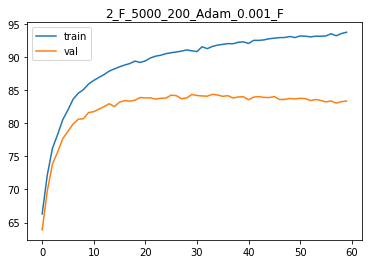

After training for 10 epochs
Train Acc 93.75
Val Acc 83.28
Test Acc 84.604


In [50]:
# List correct and incorrect predictions
# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 10 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    torch.save(model.state_dict(), 'best_model.pth')
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)
n = 2
all_ngram = 'F'
max_vocab_size = 5000
emb_dim = 200
lr = 0.001
lr_decay = 'F'
optim = 'Adam'
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)

In [56]:
train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
val_data_indices = token2index_dataset(val_data_tokens, token2id)
val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
model = BagOfWords(len(id2token), emb_dim)
model.load_state_dict(torch.load('best_model.pth'))
for i, (data, lengths, labels) in enumerate(val_loader):
    model.train()
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = model(data_batch, length_batch)
    break
predicted = outputs.max(1, keepdim=True)[1]
print(predicted.squeeze())
print(labels)

tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [64]:
# correct
print(val_data[16])
print(val_data[20])
print(val_data[14])

The very first time I saw this I recoiled in HORROR at what was being presented as modern, liberated women.<br /><br />Sorry, but I cannot relate to whining idiots whose lives revolve around loveless sex and the acquisition of Gucci, Prada and Louis Vuitton labels. The troubling thing is that some may actually think this is how career women live in NYC. It's definitely not. These women are incredibly shallow and materialistic and as another reviewer said, they act like gold-digging hooches.<br /><br />This is not liberated womanhood and I'm glad it's gone. 0 stars and just plain AWFUL
I'm Mike Sedlak. I co-wrote the score for this movie. And proud of it. <br /><br />And I love all of the comments. Some have not gone far enough.<br /><br />The movie premiered in San Francisco in the summer of 1973. The theater was packed with friends and family. We all clapped.<br /><br />Five days latter, it was pulled from all of the screens in the Bay Area.<br /><br />If anyone is interested hearing 

# Extra Points

ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.88
Epoch: [1/10], Step: [201/625], Validation Acc: 67.94
Epoch: [1/10], Step: [301/625], Validation Acc: 71.28
Epoch: [1/10], Step: [401/625], Validation Acc: 73.7
Epoch: [1/10], Step: [501/625], Validation Acc: 75.54
Epoch: [1/10], Step: [601/625], Validation Acc: 77.34
Epoch: [2/10], Step: [101/625], Validation Acc: 78.78
Epoch: [2/10], Step: [201/625], Validation Acc: 79.38
Epoch: [2/10], Step: [301/625], Validation Acc: 79.9
Epoch: [2/10], Step: [401/625], Validation Acc: 80.38
Epoch: [2/10], Step: [501/625], Validation Acc: 80.9
Epoch: [2/10], Step: [601/625], Validation Acc: 80.84
Epoch: [3/10], Step: [101/625], Validation Acc: 81.56
Epoch: [3/10], Step: [201/625], Validation Acc: 81.66
Epoch: [3/10], Step: [301/625], Validation Acc: 81.74
Epoch: [3/10], Step: [401/625], Validation Acc: 81.88
Epoch: [3/1

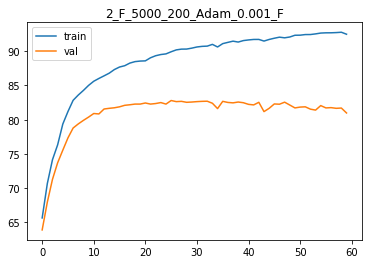

After training for 10 epochs
Train Acc 92.69
Val Acc 81.8
Test Acc 83.396
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.88
Epoch: [1/10], Step: [201/625], Validation Acc: 69.64
Epoch: [1/10], Step: [301/625], Validation Acc: 72.58
Epoch: [1/10], Step: [401/625], Validation Acc: 74.94
Epoch: [1/10], Step: [501/625], Validation Acc: 76.86
Epoch: [1/10], Step: [601/625], Validation Acc: 78.46
Epoch: [2/10], Step: [101/625], Validation Acc: 80.04
Epoch: [2/10], Step: [201/625], Validation Acc: 80.66
Epoch: [2/10], Step: [301/625], Validation Acc: 80.76
Epoch: [2/10], Step: [401/625], Validation Acc: 81.44
Epoch: [2/10], Step: [501/625], Validation Acc: 81.84
Epoch: [2/10], Step: [601/625], Validation Acc: 82.4
Epoch: [3/10], Step: [101/625], Validation Acc: 82.6
Epoch: [3/10], Step: [201/625], Validation Acc: 82.7
Epoch: [3/10], Step: [301/625], Validation Ac

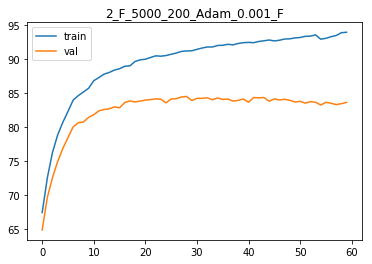

After training for 10 epochs
Train Acc 93.46
Val Acc 82.86
Test Acc 83.896
ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.42
Epoch: [1/10], Step: [201/625], Validation Acc: 69.84
Epoch: [1/10], Step: [301/625], Validation Acc: 72.46
Epoch: [1/10], Step: [401/625], Validation Acc: 76.12
Epoch: [1/10], Step: [501/625], Validation Acc: 77.68
Epoch: [1/10], Step: [601/625], Validation Acc: 79.04
Epoch: [2/10], Step: [101/625], Validation Acc: 80.14
Epoch: [2/10], Step: [201/625], Validation Acc: 80.98
Epoch: [2/10], Step: [301/625], Validation Acc: 81.84
Epoch: [2/10], Step: [401/625], Validation Acc: 82.2
Epoch: [2/10], Step: [501/625], Validation Acc: 82.54
Epoch: [2/10], Step: [601/625], Validation Acc: 83.02
Epoch: [3/10], Step: [101/625], Validation Acc: 83.52
Epoch: [3/10], Step: [201/625], Validation Acc: 83.7
Epoch: [3/10], Step: [301/625], Validation 

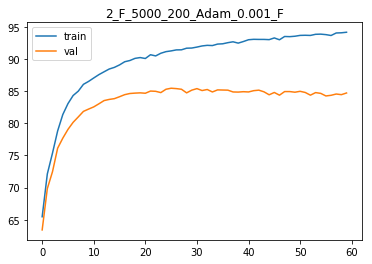

After training for 10 epochs
Train Acc 94.155
Val Acc 84.72
Test Acc 85.352


In [111]:
# Vary Extra hyperparameter MAX_SENTENCE_LENGTH 
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 10 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)
n = 2
all_ngram = 'F'
max_vocab_size = 5000
emb_dim = 200
lr = 0.001
lr_decay = 'F'
optim = 'Adam'

MAX_SENTENCE_LENGTH = 150
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
MAX_SENTENCE_LENGTH = 200
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
MAX_SENTENCE_LENGTH = 250
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)

ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/5], Step: [101/625], Validation Acc: 58.68
Epoch: [1/5], Step: [201/625], Validation Acc: 65.36
Epoch: [1/5], Step: [301/625], Validation Acc: 70.12
Epoch: [1/5], Step: [401/625], Validation Acc: 72.76
Epoch: [1/5], Step: [501/625], Validation Acc: 74.36
Epoch: [1/5], Step: [601/625], Validation Acc: 76.74
Epoch: [2/5], Step: [101/625], Validation Acc: 78.66
Epoch: [2/5], Step: [201/625], Validation Acc: 79.46
Epoch: [2/5], Step: [301/625], Validation Acc: 80.54
Epoch: [2/5], Step: [401/625], Validation Acc: 81.16
Epoch: [2/5], Step: [501/625], Validation Acc: 81.48
Epoch: [2/5], Step: [601/625], Validation Acc: 82.28
Epoch: [3/5], Step: [101/625], Validation Acc: 82.76
Epoch: [3/5], Step: [201/625], Validation Acc: 82.92
Epoch: [3/5], Step: [301/625], Validation Acc: 83.1
Epoch: [3/5], Step: [401/625], Validation Acc: 83.42
Epoch: [3/5], Step: [501/

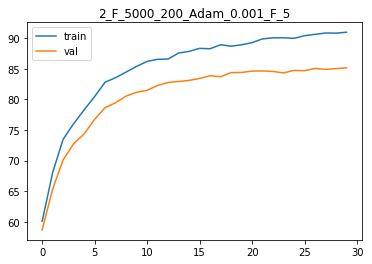

After training for 5 epochs
Train Acc 90.975
Val Acc 84.54
Test Acc 85.916


In [74]:
# Vary Extra hyperparameter number of epochs
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay, str(5)]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 5 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)
n = 2
all_ngram = 'F'
max_vocab_size = 5000
emb_dim = 200
lr = 0.001
lr_decay = 'F'
optim = 'Adam'

MAX_SENTENCE_LENGTH = 250
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)

ngram:  2
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/5], Step: [101/625], Validation Acc: 22.3
Epoch: [1/5], Step: [201/625], Validation Acc: 23.26
Epoch: [1/5], Step: [301/625], Validation Acc: 25.3
Epoch: [1/5], Step: [401/625], Validation Acc: 26.18
Epoch: [1/5], Step: [501/625], Validation Acc: 27.52
Epoch: [1/5], Step: [601/625], Validation Acc: 28.28
Epoch: [2/5], Step: [101/625], Validation Acc: 28.92
Epoch: [2/5], Step: [201/625], Validation Acc: 29.4
Epoch: [2/5], Step: [301/625], Validation Acc: 29.64
Epoch: [2/5], Step: [401/625], Validation Acc: 30.0
Epoch: [2/5], Step: [501/625], Validation Acc: 30.14
Epoch: [2/5], Step: [601/625], Validation Acc: 30.38
Epoch: [3/5], Step: [101/625], Validation Acc: 30.68
Epoch: [3/5], Step: [201/625], Validation Acc: 30.68
Epoch: [3/5], Step: [301/625], Validation Acc: 30.84
Epoch: [3/5], Step: [401/625], Validation Acc: 31.08
Epoch: [3/5], Step: [501/625

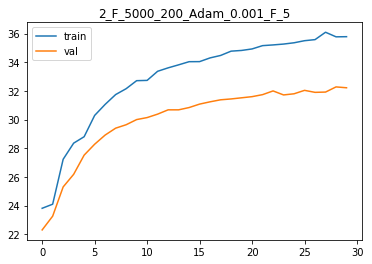

After training for 5 epochs
Train Acc 36.0
Val Acc 32.12
Test Acc 34.4


In [130]:
# classify 1-10 rating
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,10)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay, str(5)]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 5 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for i, (data, lengths, labels) in enumerate(loader):
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)
# specify directory to load
directory = '/Users/xintianhan/Downloads/nlp/aclImdb'
directory_train_neg = directory + '/train/neg'
directory_train_pos = directory + '/train/pos'
directory_test_pos = directory + '/test/pos'
directory_test_neg = directory + '/test/neg'
doc_train_pos = []
doc_train_neg = []
doc_test_pos = []
doc_test_neg = []
target_train_pos = []
target_train_neg = []
target_test_pos = []
target_test_neg = []
for filename in listdir(directory_train_neg):
    # create the full path of the file to open
    path = directory_train_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_neg.append(doc)
    target_train_pos.append(int(filename[-5]))
for filename in listdir(directory_train_pos):
    # create the full path of the file to open
    path = directory_train_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_pos.append(doc)
    target_train_neg.append(int(filename[-5]))   
for filename in listdir(directory_test_neg):
    # create the full path of the file to open
    path = directory_test_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_neg.append(doc)
    target_test_pos.append(int(filename[-5]))
for filename in listdir(directory_test_pos):
    # create the full path of the file to open
    path = directory_test_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_pos.append(doc)
    target_test_neg.append(int(filename[-5]))
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
# use 20000 data as train and 5000 as valid
# label 0-9 for the ratings.
train_data = doc_train_neg[:10000] + doc_train_pos[:10000]
train_targets = target_train_neg[:10000] + target_train_pos[:10000]
val_data = doc_train_neg[10000:] + doc_train_pos[10000:]
val_targets = target_train_neg[10000:] + target_train_pos[10000:]
test_data = doc_test_neg + doc_test_pos
test_targets = target_test_neg + target_test_pos 
best_valid_acc = 0
n = 2
all_ngram = 'F'
max_vocab_size = 5000
emb_dim = 200
lr = 0.001
lr_decay = 'F'
optim = 'Adam'
train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)